### Set up

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from collections import Counter
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import nibabel.freesurfer.io as fsio
from nilearn import datasets, plotting
import random


In [2]:
random.seed(42)
np.random.seed(42)

In [3]:
# Load the dataset
df = pd.read_csv('/Users/baileyng/MIND_data/ukb_FIS_all_no_outliers.csv', index_col=0)

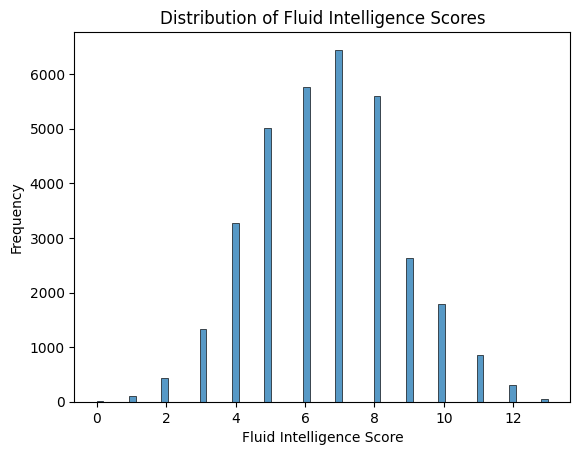

In [4]:
# Histogram of Fluid Intelligence Scores
sns.histplot(df['20016-2.0'])
plt.title('Distribution of Fluid Intelligence Scores')
plt.xlabel('Fluid Intelligence Score')
plt.ylabel('Frequency')
plt.show()

In [5]:
print(len(df))
print(df.shape)

33611
(33611, 344)


### Using MIND to predict Fluid Intelligence Score

In [6]:
# Set X and y

X = df[['31-0.0', '21003-2.0', '54-2.0',
        
        'lh_bankssts', 'lh_caudalanteriorcingulate', 'lh_caudalmiddlefrontal',
        'lh_cuneus', 'lh_entorhinal', 'lh_fusiform', 'lh_inferiorparietal', 
        'lh_inferiortemporal', 'lh_isthmuscingulate', 'lh_lateraloccipital', 
        'lh_lateralorbitofrontal', 'lh_lingual', 'lh_medialorbitofrontal', 
        'lh_middletemporal', 'lh_parahippocampal', 'lh_paracentral', 
        'lh_parsopercularis', 'lh_parsorbitalis', 'lh_parstriangularis', 
        'lh_pericalcarine', 'lh_postcentral', 'lh_posteriorcingulate', 
        'lh_precentral', 'lh_precuneus', 'lh_rostralanteriorcingulate', 
        'lh_rostralmiddlefrontal', 'lh_superiorfrontal', 'lh_superiorparietal', 
        'lh_superiortemporal', 'lh_supramarginal', 'lh_frontalpole', 
        'lh_temporalpole', 'lh_transversetemporal', 'lh_insula', 
        'rh_bankssts', 'rh_caudalanteriorcingulate', 'rh_caudalmiddlefrontal', 
        'rh_cuneus', 'rh_entorhinal', 'rh_fusiform', 'rh_inferiorparietal', 
        'rh_inferiortemporal', 'rh_isthmuscingulate', 'rh_lateraloccipital', 
        'rh_lateralorbitofrontal', 'rh_lingual', 'rh_medialorbitofrontal', 
        'rh_middletemporal', 'rh_parahippocampal', 'rh_paracentral', 
        'rh_parsopercularis', 'rh_parsorbitalis', 'rh_parstriangularis', 
        'rh_pericalcarine', 'rh_postcentral', 'rh_posteriorcingulate', 
        'rh_precentral', 'rh_precuneus', 'rh_rostralanteriorcingulate', 
        'rh_rostralmiddlefrontal', 'rh_superiorfrontal', 'rh_superiorparietal', 
        'rh_superiortemporal', 'rh_supramarginal', 'rh_frontalpole', 
        'rh_temporalpole', 'rh_transversetemporal', 'rh_insula']]

y = df['20016-2.0']

print(X.shape)
print(y.shape)

(33611, 71)
(33611,)


In [7]:
# rename columns
datafield_code = ['31-0.0', '21003-2.0', '54-2.0']

datafield_name = ['sex', 'age', 'assessment centre']

if len(datafield_code) == len(datafield_name):
    rename_dict = dict(zip(datafield_code, datafield_name))
    X = X.rename(columns=rename_dict)
    print("Columns renamed successfully.")
else:
    print("Error: The number of datafield codes does not match the number of datafield names.")

categorical_vars = ['sex', 'assessment centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

preprocessor = ColumnTransformer(transformers=[
    # scale continuous features
    ('num', StandardScaler(), continuous_vars),
    # one-hot encode the assessment centre (drop one level to avoid collinearity)
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_vars),
])

Columns renamed successfully.


In [8]:
# Cross-validation set-up
outer_cv = KFold(n_splits=10, shuffle=True, random_state=42)

outer_mae, outer_rmse, outer_r2 = [], [], []
best_params_per_fold = []
nonzero_predictors = []
coefs_list = []

for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), start=1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Inner CV
    pipe = make_pipeline(
        preprocessor,
        ElasticNetCV(
            l1_ratio=np.linspace(0.3,0.9,13),
            alphas=np.logspace(-4,2,30),
            cv=10, max_iter=5000, random_state=42
        )
    )

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    # --- metrics ---
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    outer_mae.append(mae)
    outer_rmse.append(rmse)
    outer_r2.append(r2)

    # --- store best α & l1_ratio for this fold ---
    est = pipe.named_steps['elasticnetcv']
    best_params_per_fold.append(
        {'alpha': est.alpha_, 'l1_ratio': est.l1_ratio_}
    )

    # --- predictors that survived ---
    coefs = est.coef_
    coefs_list.append(coefs)
    surviving = [col for col, c in zip(X.columns, coefs) if c != 0]
    nonzero_predictors.append(surviving)

    print(f'Fold {fold:02d} • MAE={mae:.3f} • RMSE={rmse:.3f} • R²={r2:.3f} '
          f'• α={est.alpha_:.4g} • l1_ratio={est.l1_ratio_:.2f}')
    

# Aggregate results
print('\n=== 10-fold CV summary ===')
print(f'Mean MAE :  {np.mean(outer_mae):.3f}  ± {np.std(outer_mae):.3f}')
print(f'Mean RMSE:  {np.mean(outer_rmse):.3f} ± {np.std(outer_rmse):.3f}')
print(f'Mean R²  :  {np.mean(outer_r2):.3f}  ± {np.std(outer_r2):.3f}')



Fold 01 • MAE=1.656 • RMSE=2.055 • R²=0.027 • α=0.00452 • l1_ratio=0.90
Fold 02 • MAE=1.633 • RMSE=2.026 • R²=0.036 • α=0.01172 • l1_ratio=0.30
Fold 03 • MAE=1.622 • RMSE=2.037 • R²=0.027 • α=0.007279 • l1_ratio=0.40
Fold 04 • MAE=1.649 • RMSE=2.052 • R²=0.034 • α=0.00452 • l1_ratio=0.85
Fold 05 • MAE=1.625 • RMSE=2.015 • R²=0.047 • α=0.007279 • l1_ratio=0.60
Fold 06 • MAE=1.614 • RMSE=2.005 • R²=0.031 • α=0.00452 • l1_ratio=0.90
Fold 07 • MAE=1.622 • RMSE=2.024 • R²=0.034 • α=0.007279 • l1_ratio=0.40
Fold 08 • MAE=1.641 • RMSE=2.038 • R²=0.031 • α=0.00452 • l1_ratio=0.90
Fold 09 • MAE=1.583 • RMSE=1.987 • R²=0.041 • α=0.00452 • l1_ratio=0.90
Fold 10 • MAE=1.612 • RMSE=2.006 • R²=0.024 • α=0.01172 • l1_ratio=0.30

=== 10-fold CV summary ===
Mean MAE :  1.626  ± 0.020
Mean RMSE:  2.024 ± 0.021
Mean R²  :  0.033  ± 0.007


In [9]:
# View parameter choices & surviving variables
param_df = pd.DataFrame(best_params_per_fold)
print('\nBest α and l1_ratio per fold\n', param_df)

print('\nVariables that kept non-zero coefficients in ≥1 fold:')
print(sorted({v for fold_vars in nonzero_predictors for v in fold_vars}))


Best α and l1_ratio per fold
       alpha  l1_ratio
0  0.004520      0.90
1  0.011721      0.30
2  0.007279      0.40
3  0.004520      0.85
4  0.007279      0.60
5  0.004520      0.90
6  0.007279      0.40
7  0.004520      0.90
8  0.004520      0.90
9  0.011721      0.30

Variables that kept non-zero coefficients in ≥1 fold:
['age', 'assessment centre', 'lh_bankssts', 'lh_caudalanteriorcingulate', 'lh_caudalmiddlefrontal', 'lh_cuneus', 'lh_entorhinal', 'lh_frontalpole', 'lh_fusiform', 'lh_inferiorparietal', 'lh_inferiortemporal', 'lh_insula', 'lh_isthmuscingulate', 'lh_lateraloccipital', 'lh_lateralorbitofrontal', 'lh_lingual', 'lh_medialorbitofrontal', 'lh_middletemporal', 'lh_paracentral', 'lh_parahippocampal', 'lh_parsopercularis', 'lh_parsorbitalis', 'lh_parstriangularis', 'lh_pericalcarine', 'lh_postcentral', 'lh_posteriorcingulate', 'lh_precentral', 'lh_precuneus', 'lh_rostralanteriorcingulate', 'lh_rostralmiddlefrontal', 'lh_superiorfrontal', 'lh_superiorparietal', 'lh_superior

In [10]:
# Final refit on all data
final_model = make_pipeline(
    preprocessor,
    ElasticNetCV(
        l1_ratio=np.linspace(0.3,0.9,13),
        alphas=np.logspace(-4,2,30),
        cv=10, max_iter=5000, random_state=42
    )
).fit(X, y)

print('\n=== Final model ===')
print(f"α  = {final_model['elasticnetcv'].alpha_:.4g}")
print(f"l1 = {final_model['elasticnetcv'].l1_ratio_:.2f}")


=== Final model ===
α  = 0.00452
l1 = 0.75


In [11]:
# Variable-survival summary
flat_survivors  = [v for fold in nonzero_predictors for v in fold]
survivor_counts = Counter(flat_survivors)

print('\n► Number of folds each variable survived')
for var, ct in survivor_counts.items():
    print(f'{var}: {ct}/{len(nonzero_predictors)}')

# print("\n► Survived in >50% of folds")
# for var, ct in survivor_counts.items():
#     if ct > len(nonzero_predictors) / 2:
#         print(var)

# print("\n► Survived in **all** folds")
# for var, ct in survivor_counts.items():
#     if ct == len(nonzero_predictors):
#         print(var)



► Number of folds each variable survived
sex: 10/10
age: 10/10
lh_caudalanteriorcingulate: 7/10
lh_cuneus: 10/10
lh_fusiform: 10/10
lh_inferiorparietal: 10/10
lh_isthmuscingulate: 10/10
lh_lateralorbitofrontal: 9/10
lh_lingual: 8/10
lh_middletemporal: 5/10
lh_paracentral: 10/10
lh_parsorbitalis: 10/10
lh_parstriangularis: 10/10
lh_postcentral: 10/10
lh_precentral: 10/10
lh_precuneus: 2/10
lh_rostralanteriorcingulate: 10/10
lh_rostralmiddlefrontal: 10/10
lh_superiorfrontal: 10/10
lh_superiorparietal: 10/10
lh_superiortemporal: 10/10
lh_supramarginal: 10/10
lh_frontalpole: 10/10
lh_temporalpole: 10/10
lh_transversetemporal: 10/10
lh_insula: 10/10
rh_bankssts: 10/10
rh_caudalanteriorcingulate: 10/10
rh_caudalmiddlefrontal: 10/10
rh_entorhinal: 10/10
rh_inferiorparietal: 10/10
rh_isthmuscingulate: 10/10
rh_lateraloccipital: 10/10
rh_lateralorbitofrontal: 10/10
rh_lingual: 10/10
rh_medialorbitofrontal: 10/10
rh_middletemporal: 10/10
rh_parahippocampal: 10/10
rh_parsopercularis: 10/10
rh_pa

In [12]:
print(len(nonzero_predictors))
print(np.array(coefs_list).shape)

10
(10, 72)


In [13]:
# Coefficient mean ± 95 % CI
coefs = np.vstack(coefs_list)
#print(coefs.shape)
mean_coefs = coefs.mean(axis=0)
std_coefs = coefs.std(axis=0, ddof=1)
ci95 = 1.96 * std_coefs / np.sqrt(coefs.shape[0])

feature_names = (
    final_model.named_steps['columntransformer']
    .get_feature_names_out(input_features=X.columns)
)
feature_names = [name.replace('num__', '').replace('cat__', '') for name in feature_names]

surv_mask = (coefs != 0).any(axis=0)
surv_vars = np.array(feature_names)[surv_mask]

print('\n► 95% CIs for survivors')
for n, m, ci in zip(
        surv_vars, mean_coefs[surv_mask], ci95[surv_mask]):
    print(f"{n}: {m:.3f} ± {ci:.3f}")




► 95% CIs for survivors
age: -0.105 ± 0.003
lh_bankssts: 0.052 ± 0.002
lh_caudalanteriorcingulate: 0.001 ± 0.002
lh_caudalmiddlefrontal: -0.002 ± 0.002
lh_cuneus: 0.004 ± 0.003
lh_entorhinal: -0.001 ± 0.001
lh_fusiform: 0.021 ± 0.004
lh_inferiorparietal: 0.001 ± 0.002
lh_inferiortemporal: 0.058 ± 0.004
lh_isthmuscingulate: -0.045 ± 0.002
lh_lateraloccipital: 0.001 ± 0.001
lh_lateralorbitofrontal: 0.064 ± 0.003
lh_lingual: -0.007 ± 0.003
lh_medialorbitofrontal: -0.009 ± 0.003
lh_middletemporal: -0.004 ± 0.003
lh_parahippocampal: -0.000 ± 0.000
lh_paracentral: 0.001 ± 0.001
lh_parsopercularis: -0.001 ± 0.001
lh_parsorbitalis: -0.021 ± 0.003
lh_parstriangularis: -0.000 ± 0.000
lh_pericalcarine: -0.033 ± 0.002
lh_postcentral: 0.014 ± 0.004
lh_posteriorcingulate: -0.001 ± 0.001
lh_precentral: -0.021 ± 0.004
lh_precuneus: 0.002 ± 0.003
lh_rostralanteriorcingulate: 0.078 ± 0.004
lh_rostralmiddlefrontal: 0.000 ± 0.001
lh_superiorfrontal: 0.027 ± 0.004
lh_superiorparietal: -0.045 ± 0.004
lh_su

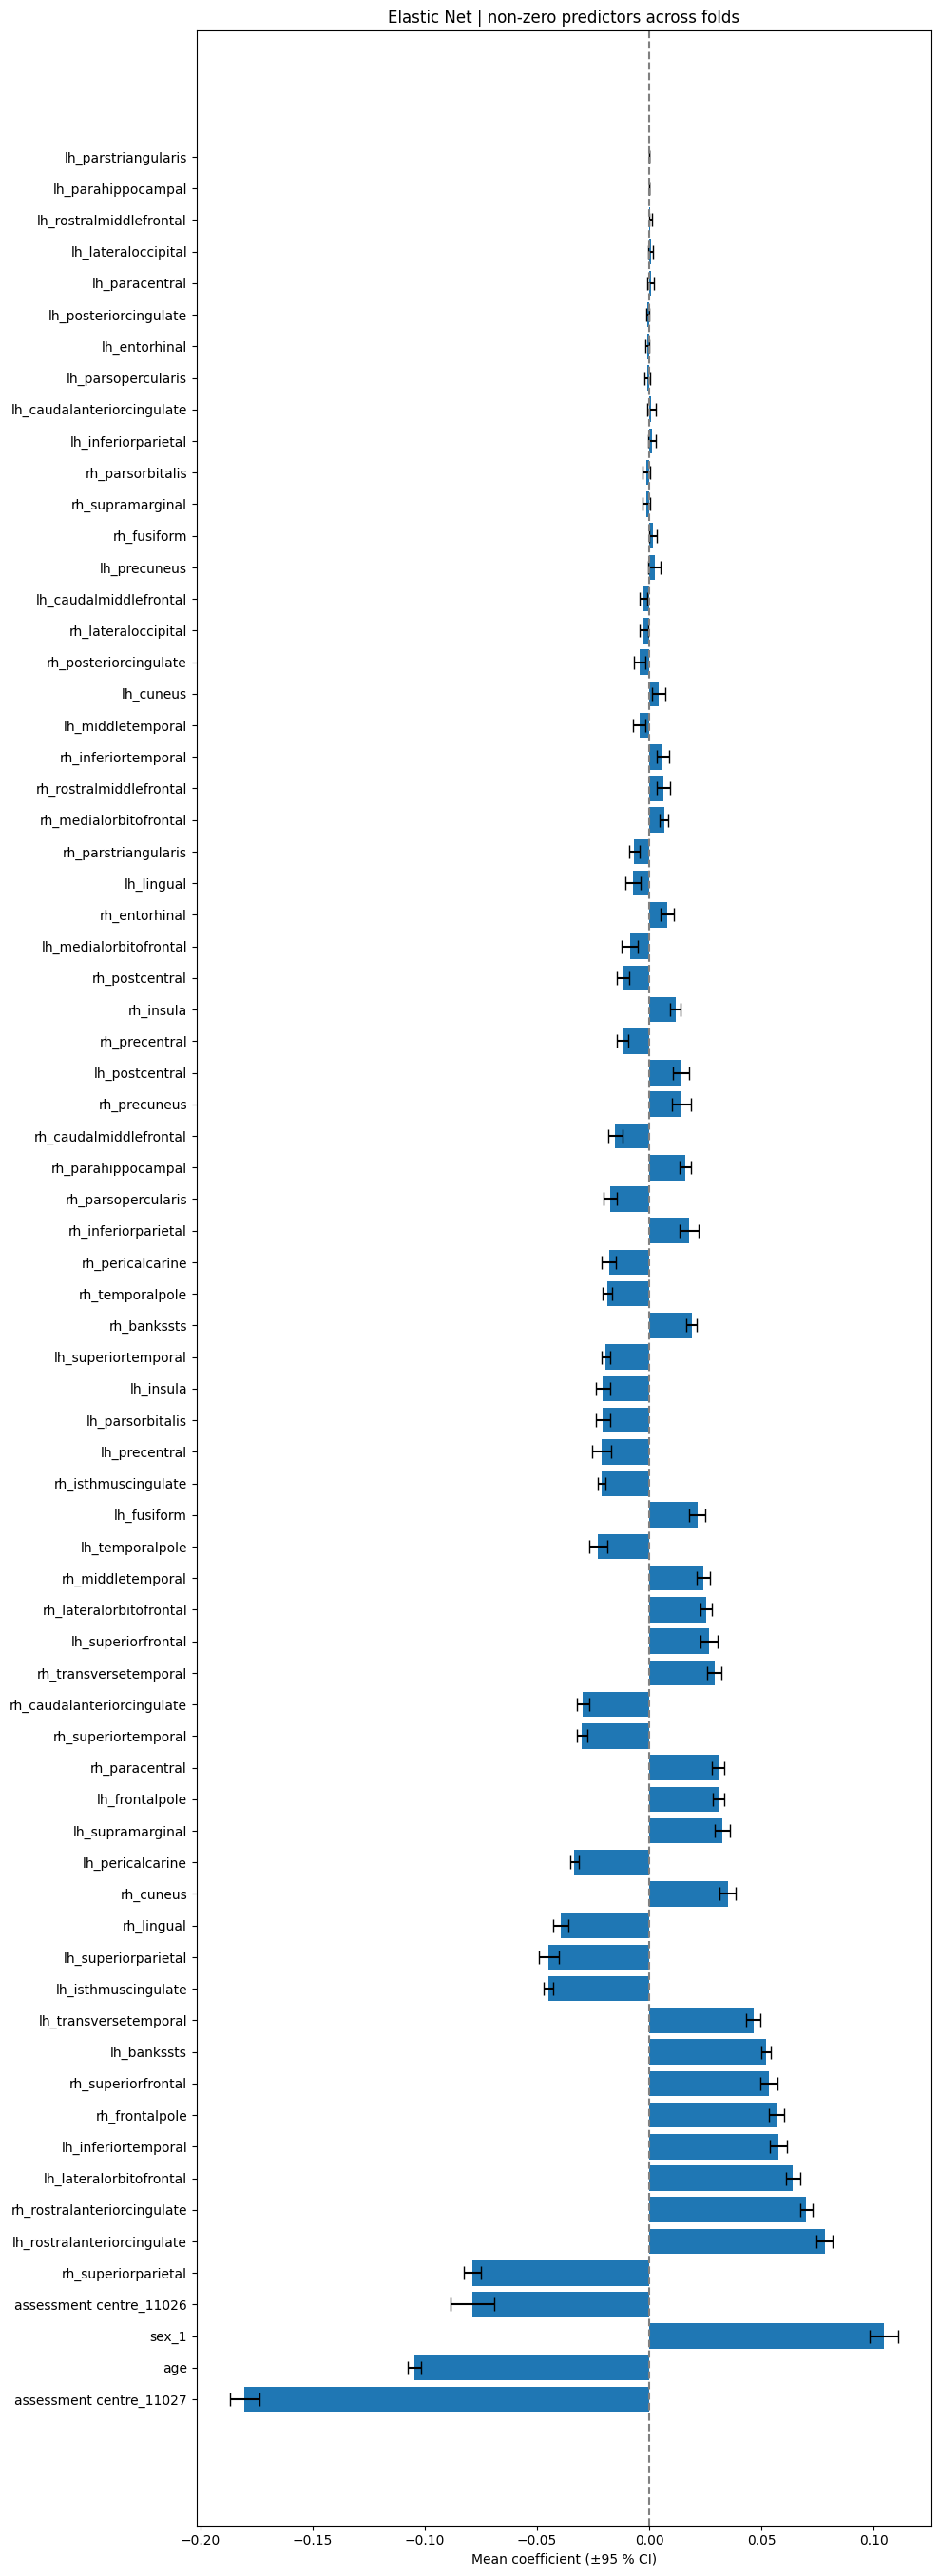

In [14]:
# Bar-plot of coefficient means + CIs
if len(surv_vars):
    order = np.argsort(np.abs(mean_coefs[surv_mask]))[::-1]
    plt.figure(figsize=(10, 0.35 * len(order) + 2))
    plt.barh(
        surv_vars[order],
        mean_coefs[surv_mask][order],
        xerr=ci95[surv_mask][order],
        capsize=5,
        ecolor='black',
    )
    plt.axvline(0, c='grey', ls='--')
    plt.xlabel('Mean coefficient (±95 % CI)')
    plt.title('Elastic Net | non-zero predictors across folds')
    plt.tight_layout()
    plt.show()

else:
    print("Nothing to plot ‒ no variables ever survived.")

In [15]:
# Strict survivors (CI never crosses zero)
low = mean_coefs - ci95
high = mean_coefs + ci95
strict_mask = surv_mask & ((low > 0) | (high < 0))

strict_vars = np.array(feature_names)[strict_mask]
print(f"\n► {strict_mask.sum()} variables whose 95% CI never crosses 0:")
for n, m, l, h in zip(
        strict_vars,
        mean_coefs[strict_mask],
        low[strict_mask],
        high[strict_mask]):
    print(f"  {n}: {m:.3f}  ({l:.3f} – {h:.3f})")


► 58 variables whose 95% CI never crosses 0:
  age: -0.105  (-0.108 – -0.102)
  lh_bankssts: 0.052  (0.050 – 0.054)
  lh_caudalmiddlefrontal: -0.002  (-0.004 – -0.001)
  lh_cuneus: 0.004  (0.001 – 0.007)
  lh_fusiform: 0.021  (0.018 – 0.025)
  lh_inferiortemporal: 0.058  (0.054 – 0.061)
  lh_isthmuscingulate: -0.045  (-0.047 – -0.043)
  lh_lateralorbitofrontal: 0.064  (0.061 – 0.067)
  lh_lingual: -0.007  (-0.010 – -0.004)
  lh_medialorbitofrontal: -0.009  (-0.012 – -0.005)
  lh_middletemporal: -0.004  (-0.007 – -0.002)
  lh_parsorbitalis: -0.021  (-0.024 – -0.018)
  lh_pericalcarine: -0.033  (-0.035 – -0.031)
  lh_postcentral: 0.014  (0.010 – 0.018)
  lh_precentral: -0.021  (-0.026 – -0.017)
  lh_rostralanteriorcingulate: 0.078  (0.075 – 0.082)
  lh_superiorfrontal: 0.027  (0.023 – 0.030)
  lh_superiorparietal: -0.045  (-0.049 – -0.040)
  lh_superiortemporal: -0.019  (-0.021 – -0.017)
  lh_supramarginal: 0.033  (0.029 – 0.036)
  lh_frontalpole: 0.031  (0.029 – 0.034)
  lh_temporalpol

In [17]:
strict_vars = [str(v) for v in strict_vars]

# 1) figure out which *original* columns we must keep
orig_keep = set()

# build a regex that matches any categorical with a suffix, e.g. "sex_1" or "assessment centre_11026"
cat_pat = re.compile(rf"^({'|'.join(map(re.escape, categorical_vars))})_")

for feat in strict_vars:
    m = cat_pat.match(feat)
    if m:
        # it’s one of your one‐hot dummies → keep the base cat var
        orig_keep.add(m.group(1))
    elif feat in continuous_vars:
        # it was a scaled continuous/region → keep it
        orig_keep.add(feat)
    else:
        # just in case something slipped through
        raise ValueError(f"Don’t know how to map “{feat}” back to X.columns")

orig_keep = sorted(orig_keep)
print("→ Re-fitting on original columns:", orig_keep)

# 2) slice X down to just those originals
X_strict = X[orig_keep]

# 3) rebuild a ColumnTransformer that only transforms those kept columns
strict_conts = [c for c in orig_keep if c not in categorical_vars]
strict_cats  = [c for c in orig_keep if c in categorical_vars]

strict_preprocessor = ColumnTransformer([
    ('num', StandardScaler(), strict_conts),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), strict_cats),
])

# 4) run your 10-fold CV
outer_cv = KFold(n_splits=10, shuffle=True, random_state=42)
maes, rmses, r2s = [], [], []

for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X_strict, y), start=1):
    X_tr, X_te = X_strict.iloc[train_idx], X_strict.iloc[test_idx]
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

    pipe = make_pipeline(
        strict_preprocessor,
        ElasticNetCV(
            l1_ratio=np.linspace(0.3,0.9,13),
            alphas=np.logspace(-4,2,30),
            cv=10, max_iter=5000, random_state=42
        )
    )

    pipe.fit(X_tr, y_tr)
    y_pred = pipe.predict(X_te)

    mae  = mean_absolute_error(y_te, y_pred)
    rmse = np.sqrt(mean_squared_error(y_te, y_pred))
    r2   = r2_score(y_te, y_pred)

    maes.append(mae)
    rmses.append(rmse)
    r2s.append(r2)

    est = pipe.named_steps['elasticnetcv']
    print(f'Fold {fold:02d} • MAE={mae:.3f} • RMSE={rmse:.3f} • R²={r2:.3f} '
          f'• α={est.alpha_:.4g} • l1_ratio={est.l1_ratio_:.2f}')

print("\n=== Re-fit on strict survivors (10-fold CV) ===")
print(f"MAE : {np.mean(maes):.3f} ± {np.std(maes):.3f}")
print(f"RMSE: {np.mean(rmses):.3f} ± {np.std(rmses):.3f}")
print(f"R²  : {np.mean(r2s):.3f} ± {np.std(r2s):.3f}")

→ Re-fitting on original columns: ['age', 'assessment centre', 'lh_bankssts', 'lh_caudalmiddlefrontal', 'lh_cuneus', 'lh_frontalpole', 'lh_fusiform', 'lh_inferiortemporal', 'lh_insula', 'lh_isthmuscingulate', 'lh_lateralorbitofrontal', 'lh_lingual', 'lh_medialorbitofrontal', 'lh_middletemporal', 'lh_parsorbitalis', 'lh_pericalcarine', 'lh_postcentral', 'lh_precentral', 'lh_rostralanteriorcingulate', 'lh_superiorfrontal', 'lh_superiorparietal', 'lh_superiortemporal', 'lh_supramarginal', 'lh_temporalpole', 'lh_transversetemporal', 'rh_bankssts', 'rh_caudalanteriorcingulate', 'rh_caudalmiddlefrontal', 'rh_cuneus', 'rh_entorhinal', 'rh_frontalpole', 'rh_inferiorparietal', 'rh_inferiortemporal', 'rh_insula', 'rh_isthmuscingulate', 'rh_lateraloccipital', 'rh_lateralorbitofrontal', 'rh_lingual', 'rh_medialorbitofrontal', 'rh_middletemporal', 'rh_paracentral', 'rh_parahippocampal', 'rh_parsopercularis', 'rh_parstriangularis', 'rh_pericalcarine', 'rh_postcentral', 'rh_posteriorcingulate', 'rh_p

/var/folders/kb/ln31wlhj2hb0n089p20hvk9r0000gn/T/ipykernel_75704/2708891461.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 1, 0.92])


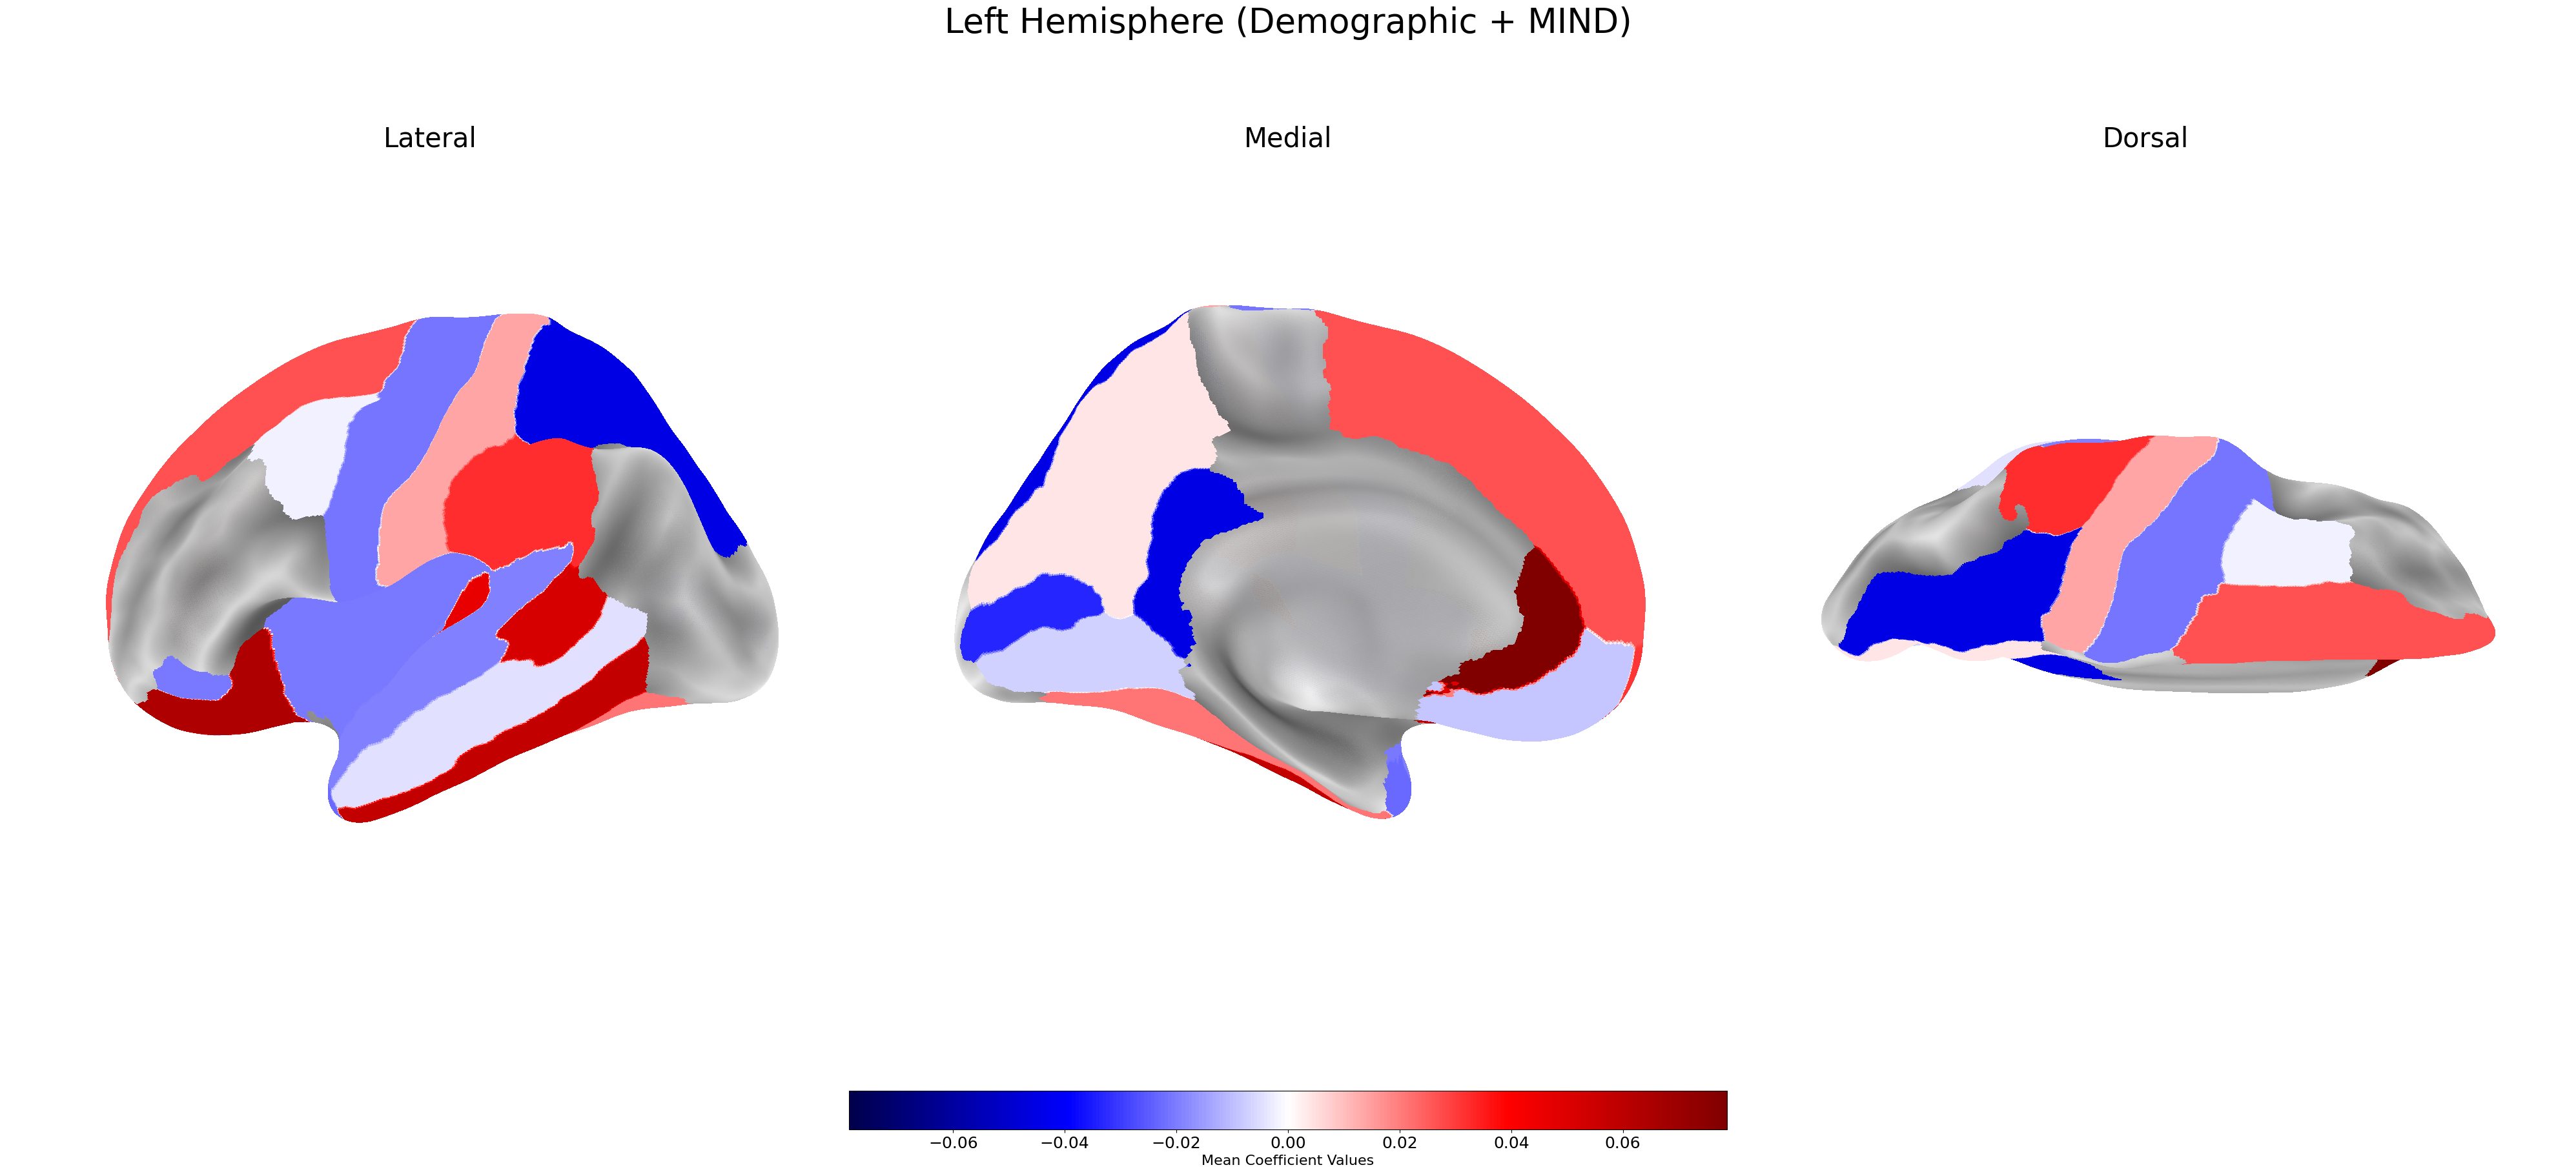

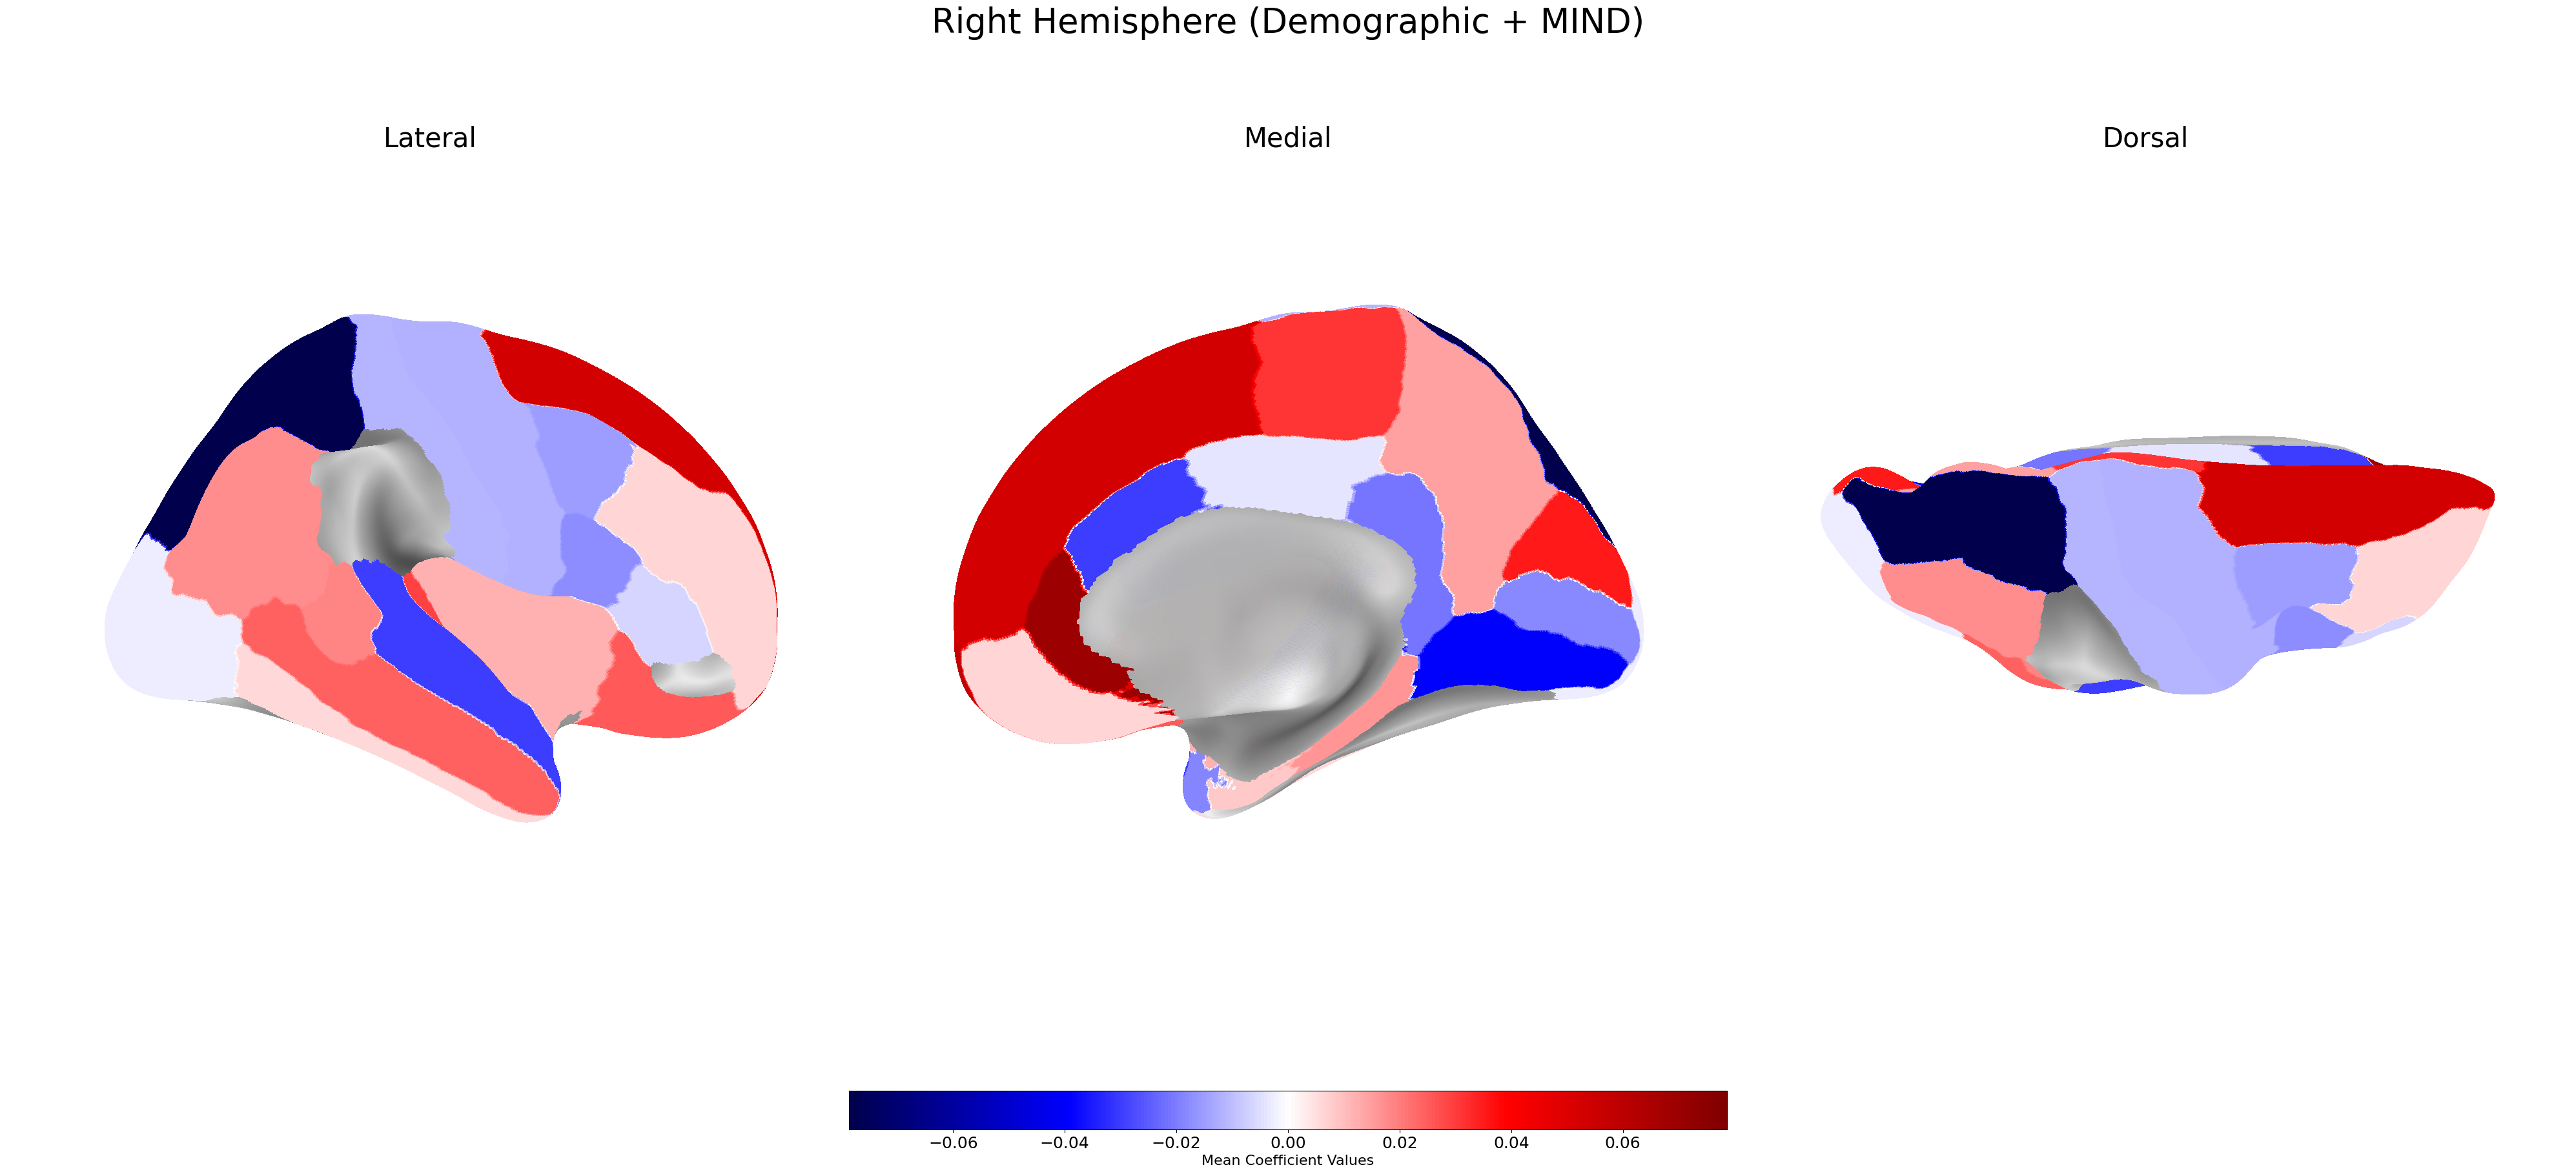

In [18]:
# 1. Variable names and coefficients
if 'strict_vars' in globals() and len(strict_vars):
    vars_to_plot = np.array(strict_vars)
    means = mean_coefs[strict_mask]
    # cis = ci95[strict_mask]
else:
    vars_to_plot = surv_vars
    means = mean_coefs[surv_mask]
    # cis = ci95[surv_mask]

# 2. Set FreeSurfer fsaverage path
fsaverage_path = '/Applications/freesurfer/subjects/fsaverage'

# 3. Load annotation files
lh_annot = fsio.read_annot(f'{fsaverage_path}/label/lh.aparc.annot')
rh_annot = fsio.read_annot(f'{fsaverage_path}/label/rh.aparc.annot')
lh_labels, lh_cmap, lh_names = lh_annot
rh_labels, rh_cmap, rh_names = rh_annot
lh_names = [name.decode('utf-8') for name in lh_names]
rh_names = [name.decode('utf-8') for name in rh_names]

# 4. Prepare vertex data arrays
lh_vertex_data = np.full_like(lh_labels, np.nan, dtype=float)
rh_vertex_data = np.full_like(rh_labels, np.nan, dtype=float)

def varname_to_region(var):
    if var.startswith('lh_'):
        return 'lh', var.replace('lh_', '').replace('_thickness', '')
    elif var.startswith('rh_'):
        return 'rh', var.replace('rh_', '').replace('_thickness', '').replace('.', '')
    return None, None

for var, coef in zip(vars_to_plot, means):
    hemi, region = varname_to_region(var)
    if hemi == 'lh':
        idxs = [i for i, n in enumerate(lh_names) if region.lower() in n.lower()]
        for idx in idxs:
            lh_vertex_data[lh_labels == idx] = coef
    elif hemi == 'rh':
        idxs = [i for i, n in enumerate(rh_names) if region.lower() in n.lower()]
        for idx in idxs:
            rh_vertex_data[rh_labels == idx] = coef

# 5. Load inflated_pre surfaces
lh_inflated_pre_path = f'{fsaverage_path}/surf/lh.inflated_pre'
rh_inflated_pre_path = f'{fsaverage_path}/surf/rh.inflated_pre'
lh_coords, lh_faces = fsio.read_geometry(lh_inflated_pre_path)
rh_coords, rh_faces = fsio.read_geometry(rh_inflated_pre_path)
lh_mesh = (lh_coords, lh_faces)
rh_mesh = (rh_coords, rh_faces)

# 6. Load fsaverage sulcal maps for background
fsavg = datasets.fetch_surf_fsaverage('fsaverage')
sulc_left = fsavg.sulc_left
sulc_right = fsavg.sulc_right

# 7. Plotting function
global_vmax = np.nanmax(np.abs(np.concatenate([lh_vertex_data, rh_vertex_data])))

def plot_three_views_custom(surf_mesh, vertex_data, bg_map, hemi, title):
    views = ['lateral', 'medial', 'dorsal']
    fig, axes = plt.subplots(1, 3, subplot_kw={'projection': '3d'}, figsize=(40, 20))
    cmap = 'seismic'
    for i, view in enumerate(views):
        plotting.plot_surf_stat_map(
            surf_mesh, vertex_data, hemi=hemi, bg_map=bg_map,
            cmap=cmap, colorbar=False, vmax=global_vmax, vmin=-global_vmax, symmetric_cbar=True,
            view=view, axes=axes[i], title='', figure=fig, alpha=0.9
        )
        axes[i].set_title(view.capitalize(), fontsize=30)
        axes[i].axis('off')
    # Colorbar
    cbar_ax = fig.add_axes([0.33, 0.09, 0.34, 0.03])
    norm = plt.Normalize(vmin=-global_vmax, vmax=global_vmax)
    cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, orientation='horizontal')
    cb.set_label('Mean Coefficient Values', fontsize=16)
    cb.ax.tick_params(labelsize=18)
    plt.suptitle(title, fontsize=38, y=0.96)
    plt.tight_layout(rect=[0, 0.15, 1, 0.92])
    plt.show()

# 8. Plot with inflated_pre
plot_three_views_custom(lh_mesh, lh_vertex_data, sulc_left, 'left', 'Left Hemisphere (Demographic + MIND)')
plot_three_views_custom(rh_mesh, rh_vertex_data, sulc_right, 'right', 'Right Hemisphere (Demographic + MIND)')


### Using Cortical Thickness to predict Fluid Intelligence Score

In [21]:
X = df[['31-0.0', '21003-2.0', '54-2.0',
        
        '27174-2.0', '27267-2.0', '27175-2.0', '27268-2.0', '27176-2.0', '27269-2.0', '27177-2.0',
        '27270-2.0', '27178-2.0', '27271-2.0', '27179-2.0', '27272-2.0', '27180-2.0', '27273-2.0',
        '27204-2.0', '27297-2.0', '27181-2.0', '27274-2.0', '27182-2.0', '27275-2.0', '27183-2.0',
        '27276-2.0', '27184-2.0', '27277-2.0', '27185-2.0', '27278-2.0', '27186-2.0', '27279-2.0',
        '27188-2.0', '27281-2.0', '27187-2.0', '27280-2.0', '27189-2.0', '27282-2.0', '27190-2.0',
        '27283-2.0', '27191-2.0', '27284-2.0', '27192-2.0', '27285-2.0', '27193-2.0', '27286-2.0',
        '27194-2.0', '27287-2.0', '27195-2.0', '27288-2.0', '27196-2.0', '27289-2.0', '27197-2.0',
        '27290-2.0', '27198-2.0', '27291-2.0', '27199-2.0', '27292-2.0', '27200-2.0', '27293-2.0',
        '27201-2.0', '27294-2.0', '27202-2.0', '27295-2.0', '27203-2.0', '27296-2.0']]

y = df['20016-2.0']

In [22]:

datafield_code = ['31-0.0', '21003-2.0', '54-2.0',
    
        '27174-2.0', '27267-2.0', '27175-2.0', '27268-2.0', '27176-2.0', '27269-2.0', '27177-2.0',
        '27270-2.0', '27178-2.0', '27271-2.0', '27179-2.0', '27272-2.0', '27180-2.0', '27273-2.0',
        '27204-2.0', '27297-2.0', '27181-2.0', '27274-2.0', '27182-2.0', '27275-2.0', '27183-2.0',
        '27276-2.0', '27184-2.0', '27277-2.0', '27185-2.0', '27278-2.0', '27186-2.0', '27279-2.0',
        '27188-2.0', '27281-2.0', '27187-2.0', '27280-2.0', '27189-2.0', '27282-2.0', '27190-2.0',
        '27283-2.0', '27191-2.0', '27284-2.0', '27192-2.0', '27285-2.0', '27193-2.0', '27286-2.0',
        '27194-2.0', '27287-2.0', '27195-2.0', '27288-2.0', '27196-2.0', '27289-2.0', '27197-2.0',
        '27290-2.0', '27198-2.0', '27291-2.0', '27199-2.0', '27292-2.0', '27200-2.0', '27293-2.0',
        '27201-2.0', '27294-2.0', '27202-2.0', '27295-2.0', '27203-2.0', '27296-2.0']

datafield_name = ['sex', 'age', 'assessment centre',
    
        'lh_caudalanteriorcingulate_thickness', 'rh_caudalanteriorcingulate_thickness', 'lh_caudalmiddlefrontal_thickness',
        'rh_caudalmiddlefrontal_thickness', 'lh_cuneus_thickness', 'rh_cuneus_thickness', 'lh_entorhinal_thickness', 
        'rh_entorhinal_thickness', 'lh_fusiform_thickness', 'rh_fusiform_thickness', 'lh_inferiorparietal_thickness', 
        'rh_inferiorparietal_thickness', 'lh_inferiortemporal_thickness', 'rh_inferiortemporal_thickness', 'lh_insula_thickness', 
        'rh_insula_thickness', 'lh_isthmuscingulate_thickness', 'rh_isthmuscingulate_thickness', 'lh_lateraloccipital_thickness', 
        'rh_lateraloccipital_thickness', 'lh_lateralorbitofrontal_thickness', 'rh_lateralorbitofrontal_thickness', 
        'lh_lingual_thickness', 'rh_lingual_thickness', 'lh_medialorbitofrontal_thickness', 'rh_medialorbitofrontal_thickness', 
        'lh_middletemporal_thickness', 'rh_middletemporal_thickness', 'lh_paracentral_thickness', 'rh_paracentral_thickness', 
        'lh_parahippocampal_thickness', 'rh_parahippocampal_thickness', 'lh_parsopercularis_thickness', 'rh_parsopercularis_thickness', 
        'lh_parsorbitalis_thickness', 'rh_parsorbitalis_thickness', 'lh_parstriangularis_thickness', 'rh_parstriangularis_thickness', 
        'lh_pericalcarine_thickness', 'rh_pericalcarine_thickness', 'lh_postcentral_thickness', 'rh_postcentral_thickness', 
        'lh_posteriorcingulate_thickness', 'rh_posteriorcingulate_thickness', 'lh_precentral_thickness', 'rh_precentral_thickness', 
        'lh_precuneus_thickness', 'rh_precuneus_thickness', 'lh_rostralanteriorcingulate_thickness', 'rh_rostralanteriorcingulate_thickness', 
        'lh_rostralmiddlefrontal_thickness', 'rh_rostralmiddlefrontal_thickness', 'lh_superiorfrontal_thickness', 'rh_superiorfrontal_thickness', 
        'lh_superiorparietal_thickness', 'rh_superiorparietal_thickness', 'lh_superiortemporal_thickness', 'rh_superiortemporal_thickness', 
        'lh_supramarginal_thickness', 'rh_supramarginal_thickness', 'lh_transversetemporal_thickness', 'rh_transversetemporal_thickness']

if len(datafield_code) == len(datafield_name):
    rename_dict = dict(zip(datafield_code, datafield_name))
    X = X.rename(columns=rename_dict)
    print("Columns renamed successfully.")
else:
    print("Error: The number of datafield codes does not match the number of datafield names.")

categorical_vars = ['sex', 'assessment centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

preprocessor = ColumnTransformer(transformers=[
    # scale continuous features
    ('num', StandardScaler(), continuous_vars),
    # one-hot encode the assessment centre (drop one level to avoid collinearity)
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_vars),
])

Columns renamed successfully.


In [23]:
# Cross-validation set-up
outer_cv = KFold(n_splits=10, shuffle=True, random_state=42)

outer_mae, outer_rmse, outer_r2 = [], [], []
best_params_per_fold = []
nonzero_predictors = []
coefs_list = []

for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), start=1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Inner CV
    pipe = make_pipeline(
        preprocessor,
        ElasticNetCV(
            l1_ratio=np.linspace(0.3,0.9,13),
            alphas=np.logspace(-4,2,30),
            cv=10, max_iter=5000, random_state=42
        )
    )

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    # --- metrics ---
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    outer_mae.append(mae)
    outer_rmse.append(rmse)
    outer_r2.append(r2)

    # --- store best α & l1_ratio for this fold ---
    est = pipe.named_steps['elasticnetcv']
    best_params_per_fold.append(
        {'alpha': est.alpha_, 'l1_ratio': est.l1_ratio_}
    )

    # --- predictors that survived ---
    coefs = est.coef_
    coefs_list.append(coefs)
    surviving = [col for col, c in zip(X.columns, coefs) if c != 0]
    nonzero_predictors.append(surviving)

    print(f'Fold {fold:02d} • MAE={mae:.3f} • RMSE={rmse:.3f} • R²={r2:.3f} '
          f'• α={est.alpha_:.4g} • l1_ratio={est.l1_ratio_:.2f}')
    

# Aggregate results
print('\n=== 10-fold CV summary ===')
print(f'Mean MAE :  {np.mean(outer_mae):.3f}  ± {np.std(outer_mae):.3f}')
print(f'Mean RMSE:  {np.mean(outer_rmse):.3f} ± {np.std(outer_rmse):.3f}')
print(f'Mean R²  :  {np.mean(outer_r2):.3f}  ± {np.std(outer_r2):.3f}')



Fold 01 • MAE=1.659 • RMSE=2.063 • R²=0.019 • α=0.007279 • l1_ratio=0.35
Fold 02 • MAE=1.645 • RMSE=2.041 • R²=0.021 • α=0.007279 • l1_ratio=0.30
Fold 03 • MAE=1.633 • RMSE=2.046 • R²=0.018 • α=0.00452 • l1_ratio=0.80
Fold 04 • MAE=1.648 • RMSE=2.049 • R²=0.036 • α=0.007279 • l1_ratio=0.30
Fold 05 • MAE=1.635 • RMSE=2.025 • R²=0.036 • α=0.007279 • l1_ratio=0.35
Fold 06 • MAE=1.620 • RMSE=2.011 • R²=0.026 • α=0.007279 • l1_ratio=0.30
Fold 07 • MAE=1.631 • RMSE=2.037 • R²=0.021 • α=0.007279 • l1_ratio=0.35
Fold 08 • MAE=1.653 • RMSE=2.051 • R²=0.019 • α=0.007279 • l1_ratio=0.35
Fold 09 • MAE=1.589 • RMSE=1.997 • R²=0.031 • α=0.007279 • l1_ratio=0.30
Fold 10 • MAE=1.619 • RMSE=2.007 • R²=0.022 • α=0.00452 • l1_ratio=0.75

=== 10-fold CV summary ===
Mean MAE :  1.633  ± 0.019
Mean RMSE:  2.033 ± 0.020
Mean R²  :  0.025  ± 0.007


In [24]:
# View parameter choices & surviving variables
param_df = pd.DataFrame(best_params_per_fold)
print('\nBest α and l1_ratio per fold\n', param_df)

print('\nVariables that kept non-zero coefficients in ≥1 fold:')
print(sorted({v for fold_vars in nonzero_predictors for v in fold_vars}))


Best α and l1_ratio per fold
       alpha  l1_ratio
0  0.007279      0.35
1  0.007279      0.30
2  0.004520      0.80
3  0.007279      0.30
4  0.007279      0.35
5  0.007279      0.30
6  0.007279      0.35
7  0.007279      0.35
8  0.007279      0.30
9  0.004520      0.75

Variables that kept non-zero coefficients in ≥1 fold:
['age', 'assessment centre', 'lh_caudalanteriorcingulate_thickness', 'lh_caudalmiddlefrontal_thickness', 'lh_cuneus_thickness', 'lh_entorhinal_thickness', 'lh_fusiform_thickness', 'lh_inferiorparietal_thickness', 'lh_inferiortemporal_thickness', 'lh_insula_thickness', 'lh_isthmuscingulate_thickness', 'lh_lateraloccipital_thickness', 'lh_lateralorbitofrontal_thickness', 'lh_lingual_thickness', 'lh_medialorbitofrontal_thickness', 'lh_middletemporal_thickness', 'lh_paracentral_thickness', 'lh_parahippocampal_thickness', 'lh_parsopercularis_thickness', 'lh_parsorbitalis_thickness', 'lh_parstriangularis_thickness', 'lh_pericalcarine_thickness', 'lh_postcentral_thicknes

In [25]:
# Final refit on all data
final_model = make_pipeline(
    preprocessor,
    ElasticNetCV(
        l1_ratio=np.linspace(0.3,0.9,13),
        alphas=np.logspace(-4,2,30),
        cv=10, max_iter=5000, random_state=42
    )
).fit(X, y)

print('\n=== Final model ===')
print(f"α  = {final_model['elasticnetcv'].alpha_:.4g}")
print(f"l1 = {final_model['elasticnetcv'].l1_ratio_:.2f}")


=== Final model ===
α  = 0.007279
l1 = 0.30


In [26]:
# Variable-survival summary
flat_survivors  = [v for fold in nonzero_predictors for v in fold]
survivor_counts = Counter(flat_survivors)

print('\n► Number of folds each variable survived')
for var, ct in survivor_counts.items():
    print(f'{var}: {ct}/{len(nonzero_predictors)}')

# print("\n► Survived in >50% of folds")
# for var, ct in survivor_counts.items():
#     if ct > len(nonzero_predictors) / 2:
#         print(var)

# print("\n► Survived in **all** folds")
# for var, ct in survivor_counts.items():
#     if ct == len(nonzero_predictors):
#         print(var)



► Number of folds each variable survived
sex: 10/10
assessment centre: 10/10
rh_caudalanteriorcingulate_thickness: 10/10
lh_caudalmiddlefrontal_thickness: 10/10
rh_caudalmiddlefrontal_thickness: 10/10
lh_cuneus_thickness: 6/10
rh_cuneus_thickness: 10/10
lh_entorhinal_thickness: 6/10
rh_entorhinal_thickness: 9/10
lh_fusiform_thickness: 10/10
rh_fusiform_thickness: 8/10
lh_inferiorparietal_thickness: 10/10
rh_inferiorparietal_thickness: 7/10
lh_inferiortemporal_thickness: 10/10
lh_insula_thickness: 10/10
rh_insula_thickness: 7/10
lh_isthmuscingulate_thickness: 10/10
rh_isthmuscingulate_thickness: 10/10
lh_lateraloccipital_thickness: 10/10
rh_lateraloccipital_thickness: 10/10
lh_lateralorbitofrontal_thickness: 3/10
rh_lateralorbitofrontal_thickness: 10/10
lh_lingual_thickness: 10/10
rh_lingual_thickness: 10/10
lh_medialorbitofrontal_thickness: 10/10
rh_medialorbitofrontal_thickness: 10/10
rh_middletemporal_thickness: 10/10
lh_paracentral_thickness: 10/10
lh_parahippocampal_thickness: 10/

In [27]:
print(len(nonzero_predictors))
print(np.array(coefs_list).shape)

10
(10, 66)


In [28]:
# Coefficient mean ± 95 % CI
coefs = np.vstack(coefs_list)
#print(coefs.shape)
mean_coefs = coefs.mean(axis=0)
std_coefs = coefs.std(axis=0, ddof=1)
ci95 = 1.96 * std_coefs / np.sqrt(coefs.shape[0])

feature_names = (
    final_model.named_steps['columntransformer']
    .get_feature_names_out(input_features=X.columns)
)
feature_names = [name.replace('num__', '').replace('cat__', '') for name in feature_names]

surv_mask = (coefs != 0).any(axis=0)
surv_vars = np.array(feature_names)[surv_mask]

print('\n► 95% CIs for survivors')
for n, m, ci in zip(
        surv_vars, mean_coefs[surv_mask], ci95[surv_mask]):
    print(f"{n}: {m:.3f} ± {ci:.3f}")




► 95% CIs for survivors
age: -0.140 ± 0.003
lh_caudalanteriorcingulate_thickness: 0.005 ± 0.003
rh_caudalanteriorcingulate_thickness: -0.038 ± 0.003
lh_caudalmiddlefrontal_thickness: 0.003 ± 0.003
rh_caudalmiddlefrontal_thickness: 0.020 ± 0.004
lh_cuneus_thickness: 0.011 ± 0.004
rh_cuneus_thickness: 0.044 ± 0.004
lh_entorhinal_thickness: 0.000 ± 0.002
rh_entorhinal_thickness: -0.015 ± 0.002
lh_fusiform_thickness: 0.005 ± 0.004
rh_fusiform_thickness: -0.006 ± 0.003
lh_inferiorparietal_thickness: -0.046 ± 0.005
rh_inferiorparietal_thickness: 0.012 ± 0.005
lh_inferiortemporal_thickness: -0.011 ± 0.003
rh_inferiortemporal_thickness: 0.005 ± 0.003
lh_insula_thickness: 0.070 ± 0.003
rh_insula_thickness: 0.003 ± 0.002
lh_isthmuscingulate_thickness: -0.018 ± 0.003
rh_isthmuscingulate_thickness: -0.003 ± 0.002
lh_lateraloccipital_thickness: -0.020 ± 0.005
rh_lateraloccipital_thickness: -0.022 ± 0.003
lh_lateralorbitofrontal_thickness: -0.028 ± 0.003
rh_lateralorbitofrontal_thickness: -0.069 ± 

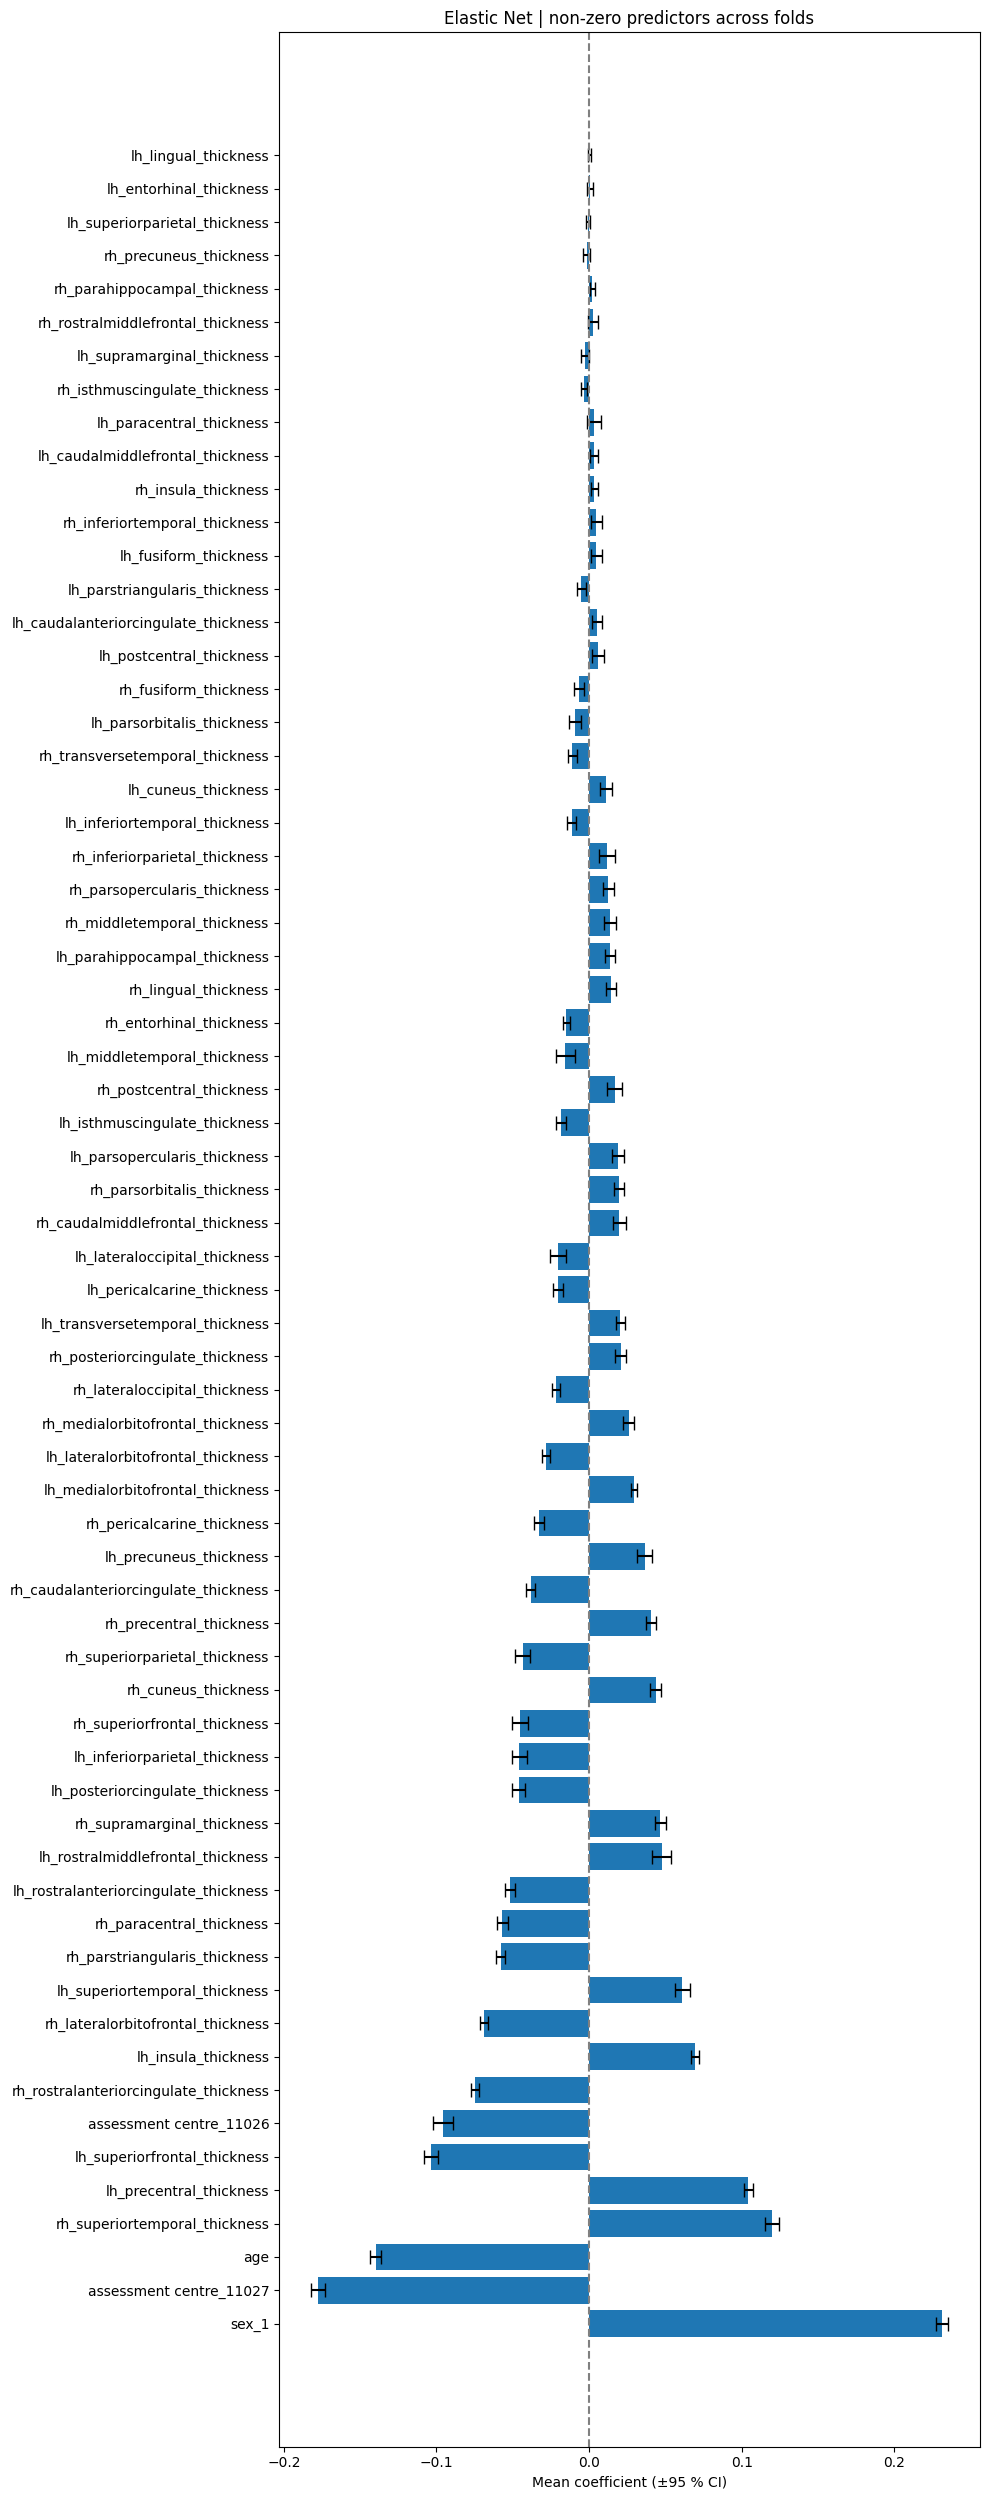

In [29]:
# Bar-plot of coefficient means + CIs
if len(surv_vars):
    order = np.argsort(np.abs(mean_coefs[surv_mask]))[::-1]
    plt.figure(figsize=(10, 0.35 * len(order) + 2))
    plt.barh(
        surv_vars[order],
        mean_coefs[surv_mask][order],
        xerr=ci95[surv_mask][order],
        capsize=5,
        ecolor='black',
    )
    plt.axvline(0, c='grey', ls='--')
    plt.xlabel('Mean coefficient (±95 % CI)')
    plt.title('Elastic Net | non-zero predictors across folds')
    plt.tight_layout()
    plt.show()

else:
    print("Nothing to plot ‒ no variables ever survived.")

In [30]:
# Strict survivors (CI never crosses zero)
low = mean_coefs - ci95
high = mean_coefs + ci95
strict_mask = surv_mask & ((low > 0) | (high < 0))

strict_vars = np.array(feature_names)[strict_mask]
print(f"\n► {strict_mask.sum()} variables whose 95% CI never crosses 0:")
for n, m, l, h in zip(
        strict_vars,
        mean_coefs[strict_mask],
        low[strict_mask],
        high[strict_mask]):
    print(f"  {n}: {m:.3f}  ({l:.3f} – {h:.3f})")


► 60 variables whose 95% CI never crosses 0:
  age: -0.140  (-0.143 – -0.137)
  lh_caudalanteriorcingulate_thickness: 0.005  (0.002 – 0.009)
  rh_caudalanteriorcingulate_thickness: -0.038  (-0.041 – -0.035)
  lh_caudalmiddlefrontal_thickness: 0.003  (0.001 – 0.006)
  rh_caudalmiddlefrontal_thickness: 0.020  (0.016 – 0.024)
  lh_cuneus_thickness: 0.011  (0.007 – 0.015)
  rh_cuneus_thickness: 0.044  (0.040 – 0.047)
  rh_entorhinal_thickness: -0.015  (-0.017 – -0.012)
  lh_fusiform_thickness: 0.005  (0.001 – 0.009)
  rh_fusiform_thickness: -0.006  (-0.010 – -0.003)
  lh_inferiorparietal_thickness: -0.046  (-0.050 – -0.041)
  rh_inferiorparietal_thickness: 0.012  (0.007 – 0.017)
  lh_inferiortemporal_thickness: -0.011  (-0.014 – -0.008)
  rh_inferiortemporal_thickness: 0.005  (0.001 – 0.008)
  lh_insula_thickness: 0.070  (0.067 – 0.072)
  rh_insula_thickness: 0.003  (0.001 – 0.006)
  lh_isthmuscingulate_thickness: -0.018  (-0.022 – -0.015)
  rh_isthmuscingulate_thickness: -0.003  (-0.005 

In [31]:
strict_vars = [str(v) for v in strict_vars]

# 1) figure out which *original* columns we must keep
orig_keep = set()

# build a regex that matches any categorical with a suffix, e.g. "sex_1" or "assessment centre_11026"
cat_pat = re.compile(rf"^({'|'.join(map(re.escape, categorical_vars))})_")

for feat in strict_vars:
    m = cat_pat.match(feat)
    if m:
        # it’s one of your one‐hot dummies → keep the base cat var
        orig_keep.add(m.group(1))
    elif feat in continuous_vars:
        # it was a scaled continuous/region → keep it
        orig_keep.add(feat)
    else:
        # just in case something slipped through
        raise ValueError(f"Don’t know how to map “{feat}” back to X.columns")

orig_keep = sorted(orig_keep)
print("→ Re-fitting on original columns:", orig_keep)

# 2) slice X down to just those originals
X_strict = X[orig_keep]

# 3) rebuild a ColumnTransformer that only transforms those kept columns
strict_conts = [c for c in orig_keep if c not in categorical_vars]
strict_cats  = [c for c in orig_keep if c in categorical_vars]

strict_preprocessor = ColumnTransformer([
    ('num', StandardScaler(), strict_conts),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), strict_cats),
])

# 4) run your 10-fold CV
outer_cv = KFold(n_splits=10, shuffle=True, random_state=42)
maes, rmses, r2s = [], [], []

for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X_strict, y), start=1):
    X_tr, X_te = X_strict.iloc[train_idx], X_strict.iloc[test_idx]
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

    pipe = make_pipeline(
        strict_preprocessor,
        ElasticNetCV(
            l1_ratio=np.linspace(0.3,0.9,13),
            alphas=np.logspace(-4,2,30),
            cv=10, max_iter=5000, random_state=42
        )
    )

    pipe.fit(X_tr, y_tr)
    y_pred = pipe.predict(X_te)

    mae  = mean_absolute_error(y_te, y_pred)
    rmse = np.sqrt(mean_squared_error(y_te, y_pred))
    r2   = r2_score(y_te, y_pred)

    maes.append(mae)
    rmses.append(rmse)
    r2s.append(r2)

    est = pipe.named_steps['elasticnetcv']
    print(f'Fold {fold:02d} • MAE={mae:.3f} • RMSE={rmse:.3f} • R²={r2:.3f} '
          f'• α={est.alpha_:.4g} • l1_ratio={est.l1_ratio_:.2f}')

print("\n=== Re-fit on strict survivors (10-fold CV) ===")
print(f"MAE : {np.mean(maes):.3f} ± {np.std(maes):.3f}")
print(f"RMSE: {np.mean(rmses):.3f} ± {np.std(rmses):.3f}")
print(f"R²  : {np.mean(r2s):.3f} ± {np.std(r2s):.3f}")

→ Re-fitting on original columns: ['age', 'assessment centre', 'lh_caudalanteriorcingulate_thickness', 'lh_caudalmiddlefrontal_thickness', 'lh_cuneus_thickness', 'lh_fusiform_thickness', 'lh_inferiorparietal_thickness', 'lh_inferiortemporal_thickness', 'lh_insula_thickness', 'lh_isthmuscingulate_thickness', 'lh_lateraloccipital_thickness', 'lh_lateralorbitofrontal_thickness', 'lh_medialorbitofrontal_thickness', 'lh_middletemporal_thickness', 'lh_parahippocampal_thickness', 'lh_parsopercularis_thickness', 'lh_parsorbitalis_thickness', 'lh_parstriangularis_thickness', 'lh_pericalcarine_thickness', 'lh_postcentral_thickness', 'lh_posteriorcingulate_thickness', 'lh_precentral_thickness', 'lh_precuneus_thickness', 'lh_rostralanteriorcingulate_thickness', 'lh_rostralmiddlefrontal_thickness', 'lh_superiorfrontal_thickness', 'lh_superiortemporal_thickness', 'lh_supramarginal_thickness', 'lh_transversetemporal_thickness', 'rh_caudalanteriorcingulate_thickness', 'rh_caudalmiddlefrontal_thickness

/var/folders/kb/ln31wlhj2hb0n089p20hvk9r0000gn/T/ipykernel_75704/540859951.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 1, 0.92])


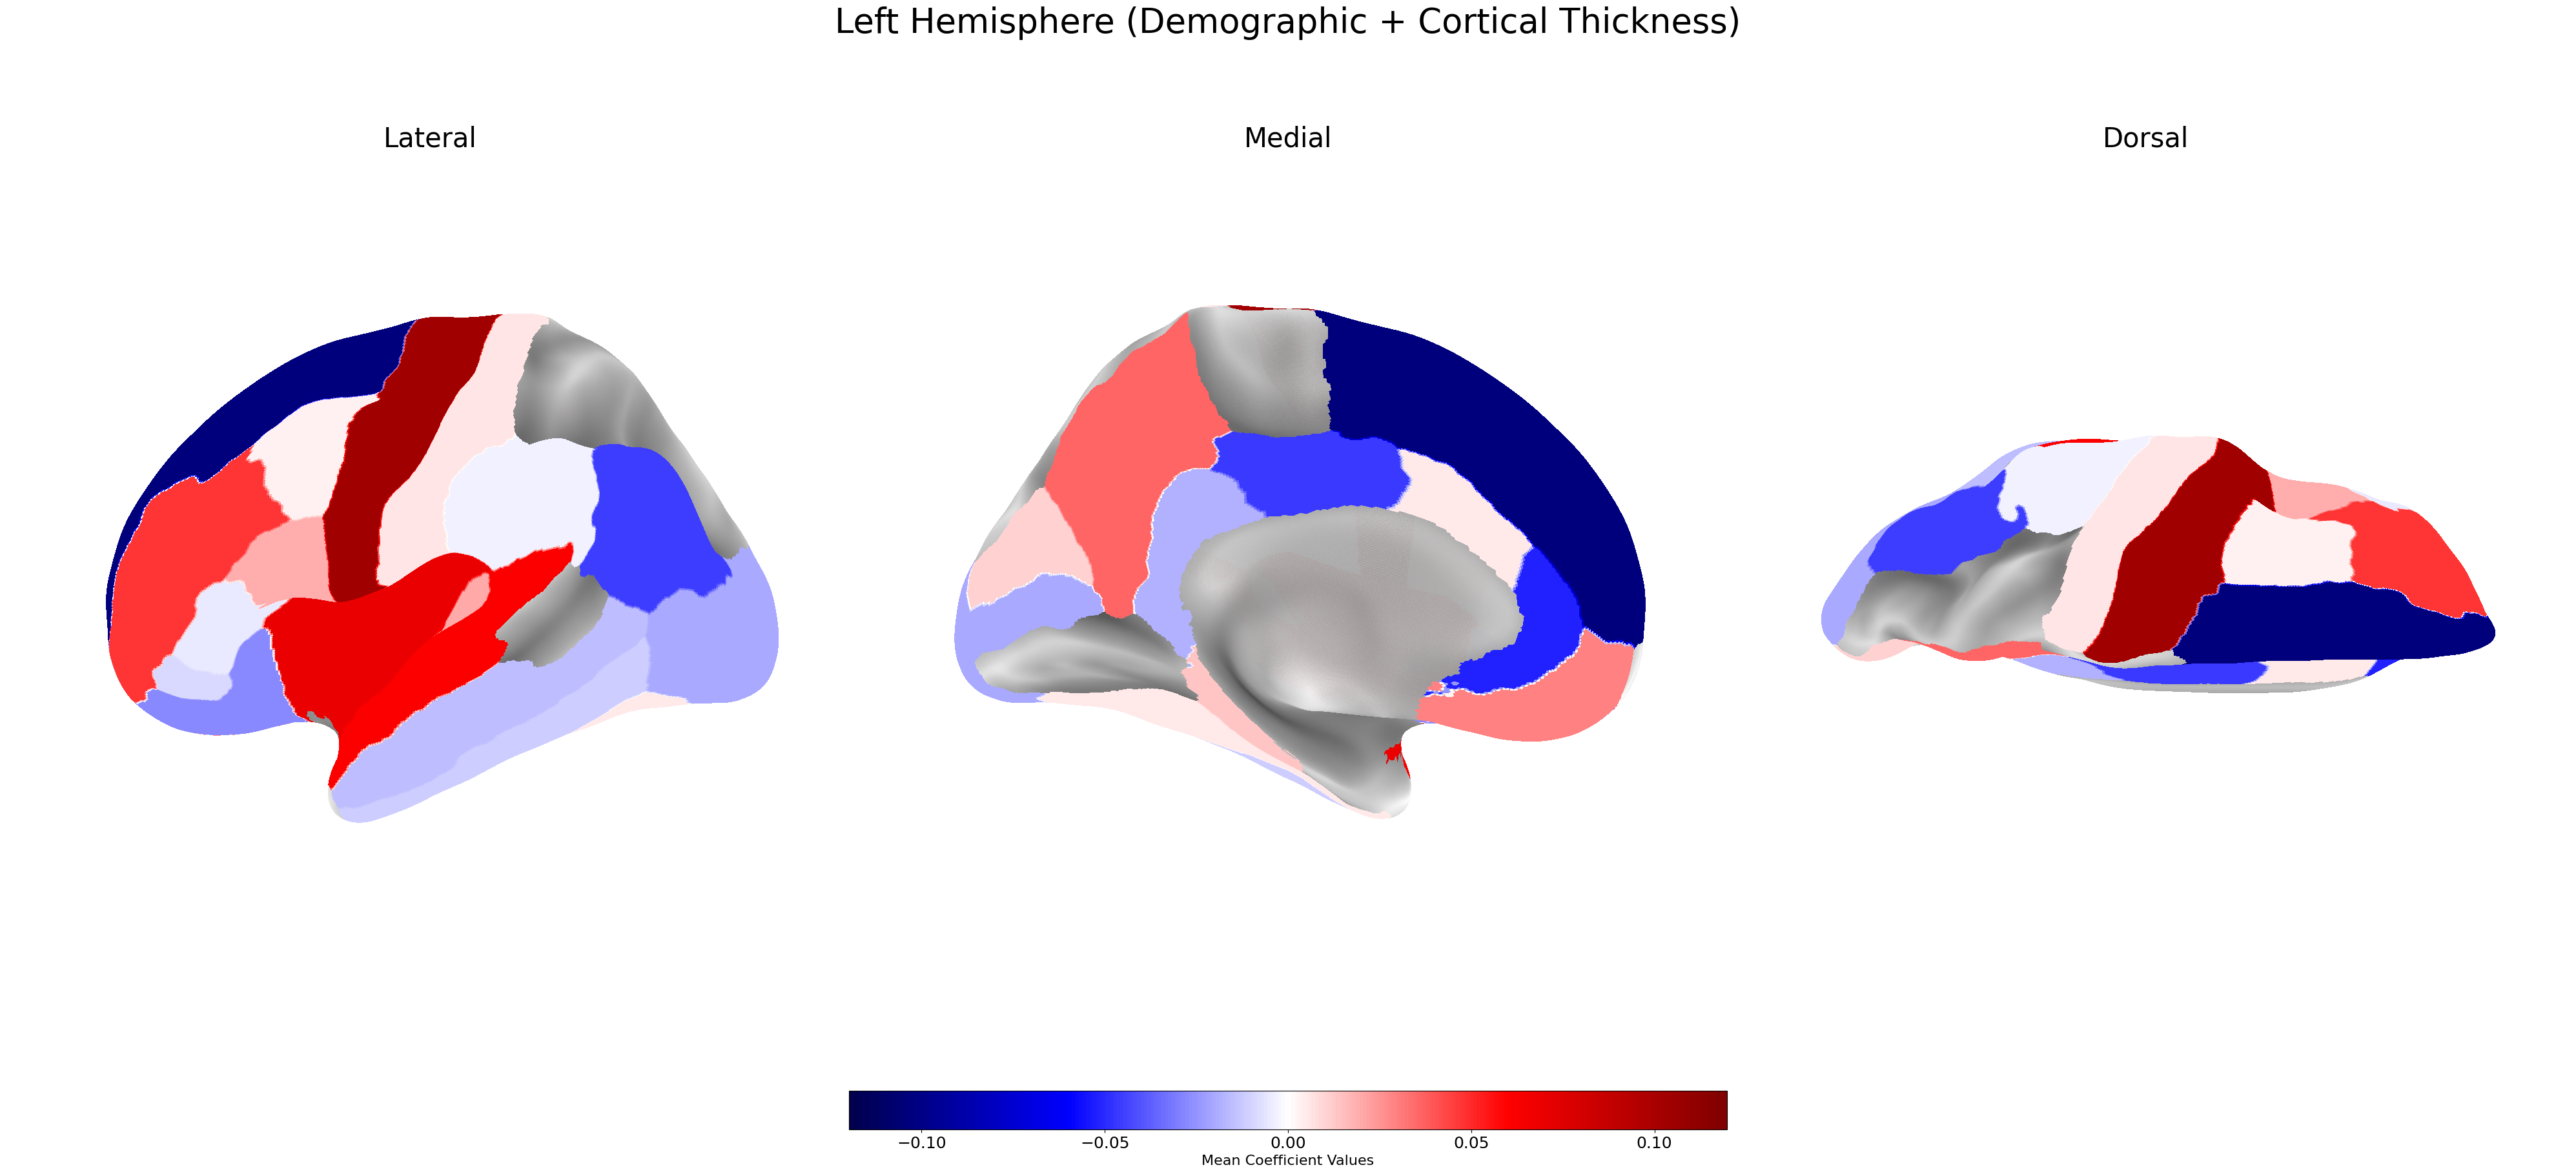

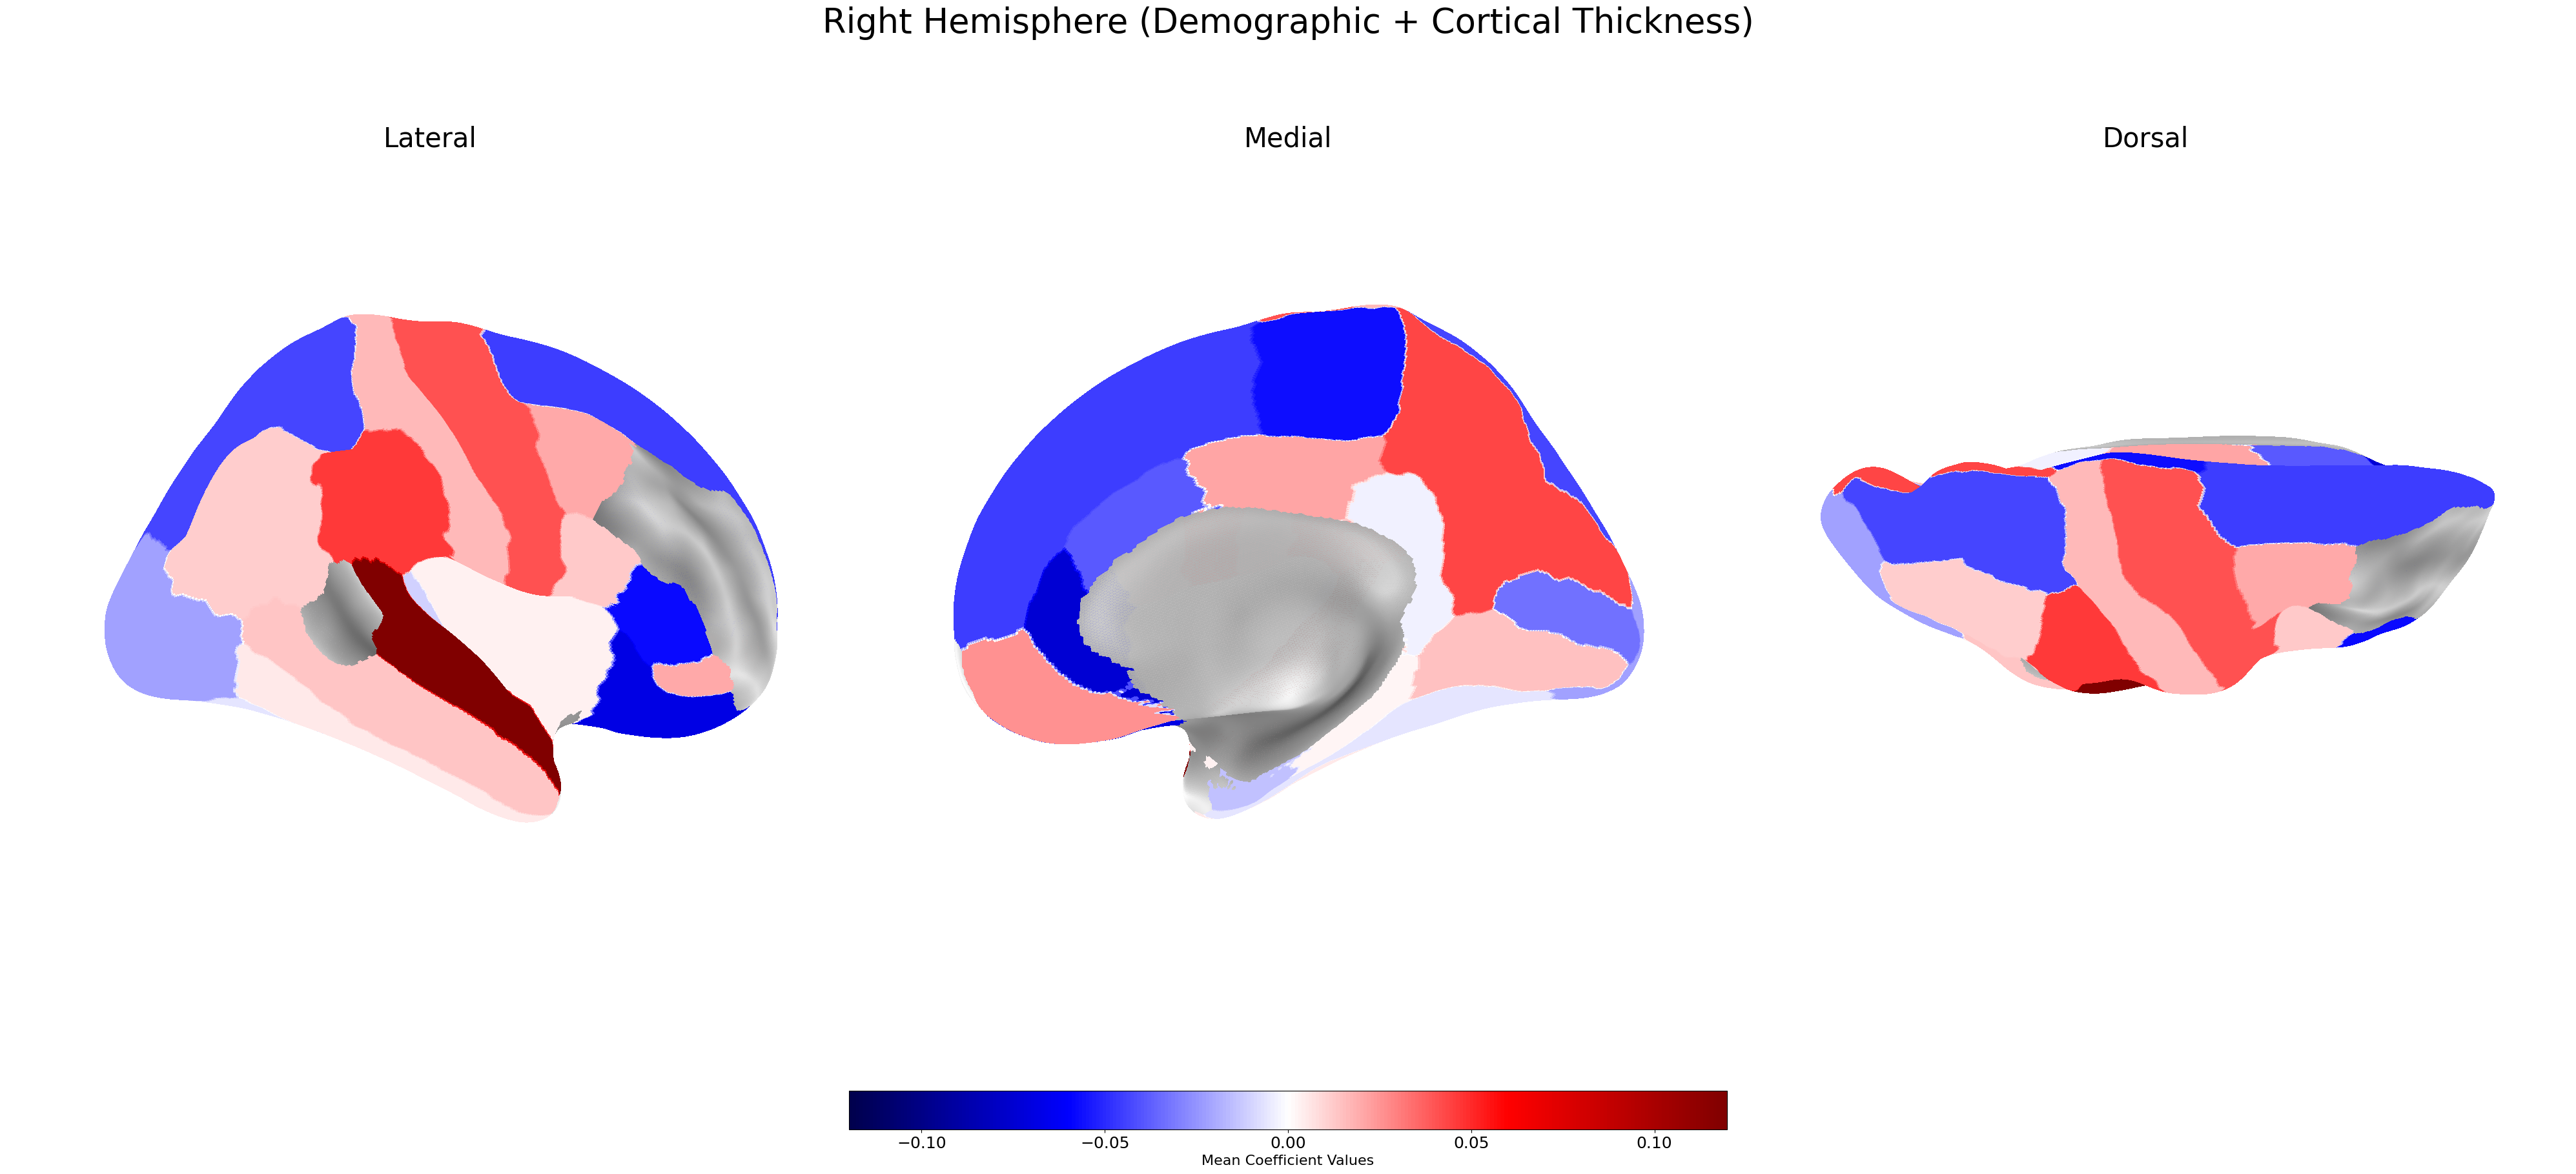

In [32]:
# 1. Variable names and coefficients
if 'strict_vars' in globals() and len(strict_vars):
    vars_to_plot = np.array(strict_vars)
    means = mean_coefs[strict_mask]
    # cis = ci95[strict_mask]
else:
    vars_to_plot = surv_vars
    means = mean_coefs[surv_mask]
    # cis = ci95[surv_mask]

# 2. Set FreeSurfer fsaverage path
fsaverage_path = '/Applications/freesurfer/subjects/fsaverage'

# 3. Load annotation files
lh_annot = fsio.read_annot(f'{fsaverage_path}/label/lh.aparc.annot')
rh_annot = fsio.read_annot(f'{fsaverage_path}/label/rh.aparc.annot')
lh_labels, lh_cmap, lh_names = lh_annot
rh_labels, rh_cmap, rh_names = rh_annot
lh_names = [name.decode('utf-8') for name in lh_names]
rh_names = [name.decode('utf-8') for name in rh_names]

# 4. Prepare vertex data arrays
lh_vertex_data = np.full_like(lh_labels, np.nan, dtype=float)
rh_vertex_data = np.full_like(rh_labels, np.nan, dtype=float)

def varname_to_region(var):
    if var.startswith('lh_'):
        return 'lh', var.replace('lh_', '').replace('_thickness', '')
    elif var.startswith('rh_'):
        return 'rh', var.replace('rh_', '').replace('_thickness', '').replace('.', '')
    return None, None

for var, coef in zip(vars_to_plot, means):
    hemi, region = varname_to_region(var)
    if hemi == 'lh':
        idxs = [i for i, n in enumerate(lh_names) if region.lower() in n.lower()]
        for idx in idxs:
            lh_vertex_data[lh_labels == idx] = coef
    elif hemi == 'rh':
        idxs = [i for i, n in enumerate(rh_names) if region.lower() in n.lower()]
        for idx in idxs:
            rh_vertex_data[rh_labels == idx] = coef

# 5. Load inflated_pre surfaces
lh_inflated_pre_path = f'{fsaverage_path}/surf/lh.inflated_pre'
rh_inflated_pre_path = f'{fsaverage_path}/surf/rh.inflated_pre'
lh_coords, lh_faces = fsio.read_geometry(lh_inflated_pre_path)
rh_coords, rh_faces = fsio.read_geometry(rh_inflated_pre_path)
lh_mesh = (lh_coords, lh_faces)
rh_mesh = (rh_coords, rh_faces)

# 6. Load fsaverage sulcal maps for background
fsavg = datasets.fetch_surf_fsaverage('fsaverage')
sulc_left = fsavg.sulc_left
sulc_right = fsavg.sulc_right

# 7. Plotting function
global_vmax = np.nanmax(np.abs(np.concatenate([lh_vertex_data, rh_vertex_data])))

def plot_three_views_custom(surf_mesh, vertex_data, bg_map, hemi, title):
    views = ['lateral', 'medial', 'dorsal']
    fig, axes = plt.subplots(1, 3, subplot_kw={'projection': '3d'}, figsize=(40, 20))
    cmap = 'seismic'
    for i, view in enumerate(views):
        plotting.plot_surf_stat_map(
            surf_mesh, vertex_data, hemi=hemi, bg_map=bg_map,
            cmap=cmap, colorbar=False, vmax=global_vmax, vmin=-global_vmax, symmetric_cbar=True,
            view=view, axes=axes[i], title='', figure=fig, alpha=0.9
        )
        axes[i].set_title(view.capitalize(), fontsize=30)
        axes[i].axis('off')
    # Colorbar
    cbar_ax = fig.add_axes([0.33, 0.09, 0.34, 0.03])
    norm = plt.Normalize(vmin=-global_vmax, vmax=global_vmax)
    cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, orientation='horizontal')
    cb.set_label('Mean Coefficient Values', fontsize=16)
    cb.ax.tick_params(labelsize=18)
    plt.suptitle(title, fontsize=38, y=0.96)
    plt.tight_layout(rect=[0, 0.15, 1, 0.92])
    plt.show()

# 8. Plot with inflated_pre
plot_three_views_custom(lh_mesh, lh_vertex_data, sulc_left, 'left', 'Left Hemisphere (Demographic + Cortical Thickness)')
plot_three_views_custom(rh_mesh, rh_vertex_data, sulc_right, 'right', 'Right Hemisphere (Demographic + Cortical Thickness)')
